# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix





Importing necessary libraries used for machine learning and data preprocessing

In [313]:
recipe = pd.read_csv('recipe_site_traffic_2212.csv')

In [314]:
print(recipe.head())
print(recipe.columns)
print(recipe.info())

   recipe  calories  carbohydrate  ...   category  servings high_traffic
0       1       NaN           NaN  ...       Pork         6         High
1       2     35.48         38.56  ...     Potato         4         High
2       3    914.28         42.68  ...  Breakfast         1          NaN
3       4     97.03         30.56  ...  Beverages         4         High
4       5     27.05          1.85  ...  Beverages         4          NaN

[5 rows x 8 columns]
Index(['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'servings', 'high_traffic'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64


Checking null values, how data is structured and what can be used / dropped. 

In [315]:
recipe.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

**Data Validation**

This data set has 947 rows, 8 columns. The calories, carbohydrates, sugar and protein columns have 52 null values within the same rows. I will drop these rows as I believe it is important for training our model. I have not used imputation such as with 0s or with the mean/median as I believe this will incorrectly train the model being built. The High_traffic column had 360 null values (after dropping the previous 52), where these null values are meaningful referring to when a recipe did not have high traffic. 

- recipe: 947 unique numeric values without missing values. No cleaning needed.
- calories: numeric. 52 null values, null values dropped.
- carbohydrate: numeric. 52 null vlaues, null values dropped
- sugar: numeric. 52 null values, null values dropped. 
- protein: numeric. 52 null values, null values dropped. 
- category: 11 categories with no missing values. Supposed to be 10 categories so Chicken Breast moved to Chicken
- servings: no missing values, 6 categories, 2 of which belong in another category. 2 labels moved to form 4 labels by dropping text ' as a snack' and changed to integer datatype.
- high_traffic: 373 null values, after dropping the 52 rows, 360 remain which refer to low traffic, these were replaced with 0s by using a label encoder. 2 categories - 1 referring to high traffic, 0 to low traffic.


- We will drop all rows with null values in the protein/sugar/carb/calories columns
- We will assume that null values of high_values mean the recipe didn't do well on the web page and convert this as 0 instead of null so it can be used to train.
- The assumption from the data is that all recipes have been featured on the website and that null values in high traffic column mean low traffic

In [316]:
recipe.dropna(subset=['calories'], inplace=True)

In [317]:
recipe.isna().sum()

recipe            0
calories          0
carbohydrate      0
sugar             0
protein           0
category          0
servings          0
high_traffic    360
dtype: int64

**Exploratory Analysis**
- Boxplots of Calories, Carbohydrate, Sugar, Protein
- Count plot of Category and servings and if they relate to higher traffic

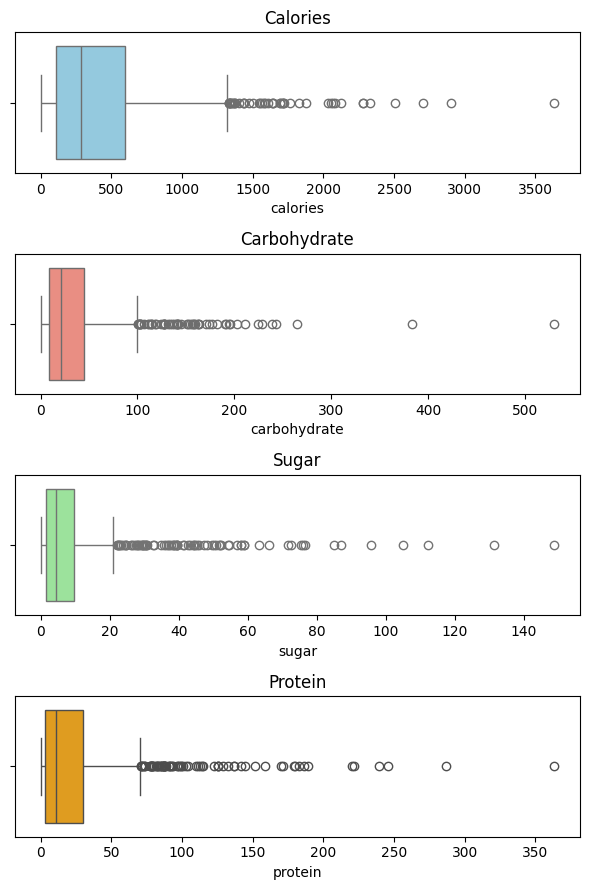

In [318]:

fig, axes = plt.subplots(4, 1, figsize=(6, 9))

sns.boxplot(ax=axes[0], x='calories', data=recipe, color='skyblue')
axes[0].set_title('Calories')

sns.boxplot(ax=axes[1], x='carbohydrate', data=recipe, color='salmon')
axes[1].set_title('Carbohydrate')

sns.boxplot(ax=axes[2], x='sugar', data=recipe, color='lightgreen')
axes[2].set_title('Sugar')

sns.boxplot(ax=axes[3], x='protein', data=recipe, color='orange')
axes[3].set_title('Protein')


plt.tight_layout()
plt.show()

- From the boxplot, there appears to be many outliers in each category but on closer inspection it looks like these have been scaled to the servings for the recipe i.e. content of sugar/protein/carbs/calories refer to per serving

In [319]:
#replace the null values in high traffic column with 0
recipe['high_traffic'].fillna('0', inplace=True)

In [320]:
recipe.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

In [321]:
print(recipe['category'].value_counts())
print(recipe['servings'].value_counts())
print(recipe['high_traffic'].value_counts())

Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: category, dtype: int64
4               365
6               184
2               174
1               169
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64
High    535
0       360
Name: high_traffic, dtype: int64


- From looking at the brief given by the product manager, they stated 10 categories with no 'Chicken Breast' category so it appears this was incorrectly categorized and should be moved into the 'Chicken' category.

- Making sure data is properly categorised - 4 as a snack meaning 4 servings.
- Chicken Breast as Chicken

In [322]:
recipe['servings'] = recipe['servings'].replace('4 as a snack', '4')
recipe['servings'] = recipe['servings'].replace('6 as a snack', '6')
recipe['category'] = recipe['category'].replace('Chicken Breast', 'Chicken')


In [323]:
recipe['servings'].value_counts()

4    367
6    185
2    174
1    169
Name: servings, dtype: int64

In [324]:
le = LabelEncoder()
le.fit(recipe['high_traffic'])
recipe['high_traffic'] = le.transform(recipe['high_traffic'])

In [325]:
recipe['high_traffic'].value_counts()

1    535
0    360
Name: high_traffic, dtype: int64

In [326]:
recipe['servings'] = recipe['servings'].astype('int')

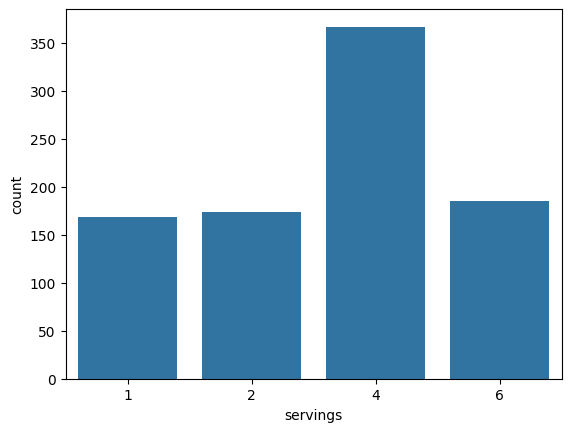

In [327]:
sns.countplot(x='servings', data=recipe )
plt.show()

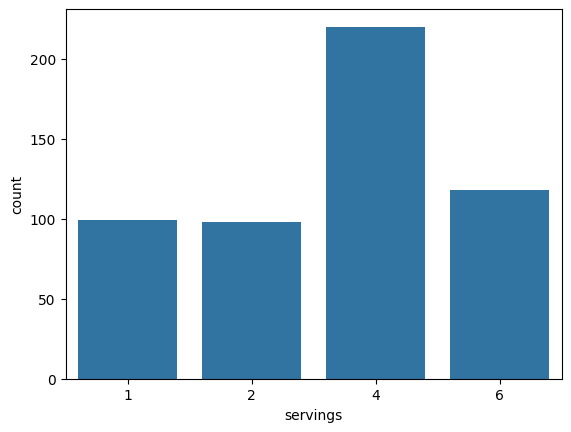

In [328]:
high_traffic_bar = recipe[recipe['high_traffic'] == 1]
sns.countplot(x='servings', data=high_traffic_bar )
plt.show()

- Seeing if the amount of servings from the recipe influenced whether there was high traffic, it looks as though servings with 4 seem to be more popular than recipes with other amount of servings but this is in proportion to the amount of 4 serving recipes that were displayed on the website so would not contribute to whether a recipe was high raffic. 
- Using a boxplot of each category for high traffic, we can see if here were large differences between higher amounts of those categories. We see that there didn't seem to be significant differences perhaps only when we look at the outliers of calories and protein in the high traffic categories.

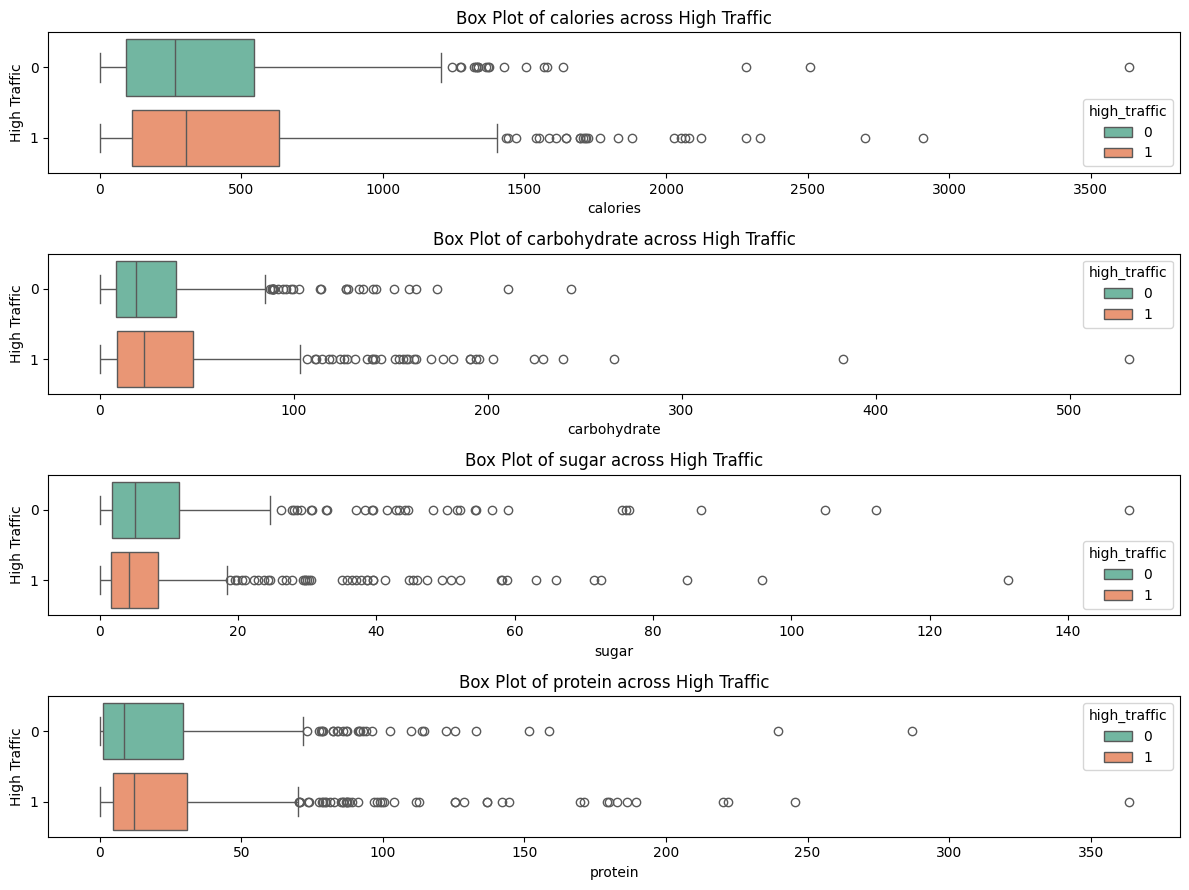

In [329]:
nutrients = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create subplots with appropriate figure size
fig, axes = plt.subplots(len(nutrients), 1, figsize=(12, 9))

# Iterate over each nutrient and create a box plot
for i, nutrient in enumerate(nutrients):
    sns.boxplot(ax=axes[i], x=nutrient, y='high_traffic', data=recipe, hue='high_traffic', orient='h', palette='Set2')
    axes[i].set_title(f'Box Plot of {nutrient} across High Traffic')
    axes[i].set_xlabel(nutrient)
    axes[i].set_ylabel('High Traffic')

# Adjust layout
plt.tight_layout()
plt.show()

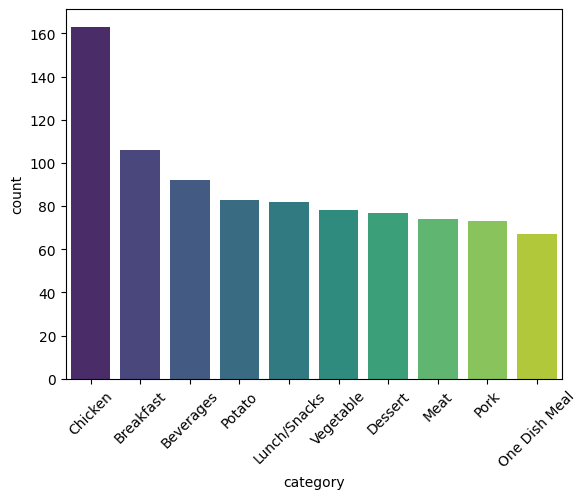

In [330]:
category_counts = recipe['category'].value_counts()
sorted_categories = category_counts.sort_values(ascending=False).index
sns.countplot(x='category', data=recipe, palette='viridis', order=sorted_categories)
plt.xticks(rotation=45)
plt.show()

- We can see from the above the order of more featured recipes for overall count.
- from below we see that the order differs when we only look at only high traffic recipes

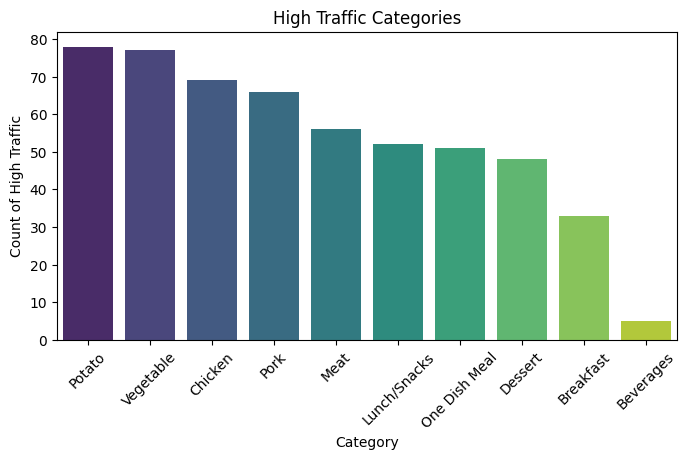

In [331]:
#Catgories with the highest traffic
high_traffic_category = recipe[recipe['high_traffic'] == 1]
category_counts = high_traffic_category['category'].value_counts()
sorted_categories = category_counts.sort_values(ascending=False).index
plt.figure(figsize=(8, 4))
sns.countplot(data=high_traffic_category, x='category', palette='viridis', order=sorted_categories)
plt.xticks(rotation=45)

plt.title('High Traffic Categories')
plt.xlabel('Category')
plt.ylabel('Count of High Traffic')

plt.show()

**Model Development**

- As this is a classification problem with target variable high or low traffic we will build a machine learning model using the most popular classification algorithms and compare their accuracy i.e. DecisionTreeClassifier, RandomForestClassifier,LogisticRegression, K nearest neighbours classifier. 
- We can use the confusion matrix to look at precision and recall scores, particular precision to see how many correctly identified positives (high traffic) were identified from the test set. 
- We created dummy variables for category columns so they can be used for machine learning.
- We used a label encoder for the target variable 1 for high traffic 0 for low traffic and dropped columns that we won't use for machine learning i.e. recipe, category (after creating dummy variables)
- We split the data into the train and test set with stratify to ensure equal class representation that represents the overall dataset

In [332]:
category_dummies = pd.get_dummies(recipe['category'], prefix='')
recipe = pd.concat([recipe, category_dummies], axis=1)
recipe.drop('category', axis=1, inplace=True)

In [333]:
print(recipe.columns)

Index(['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'servings',
       'high_traffic', '_Beverages', '_Breakfast', '_Chicken', '_Dessert',
       '_Lunch/Snacks', '_Meat', '_One Dish Meal', '_Pork', '_Potato',
       '_Vegetable'],
      dtype='object')


In [334]:
#create target variable and feature variables
columns_to_drop = ['recipe', 'high_traffic']
X = recipe.drop(columns=columns_to_drop)
y = recipe['high_traffic']

In [335]:
print(X.columns)

Index(['calories', 'carbohydrate', 'sugar', 'protein', 'servings',
       '_Beverages', '_Breakfast', '_Chicken', '_Dessert', '_Lunch/Snacks',
       '_Meat', '_One Dish Meal', '_Pork', '_Potato', '_Vegetable'],
      dtype='object')


In [336]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
#Normalize the numeric features of data with standard scaler
scaler = StandardScaler()

# columns to scale
columns_to_scale = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


In [337]:
dt = DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.776536312849162


In [338]:
lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy_lr)

Accuracy: 0.7988826815642458


In [339]:

rf = RandomForestClassifier(n_estimators=350, max_depth=10, min_samples_leaf=2, random_state=20)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)
print("Parameters used", rf.get_params())

Accuracy: 0.7877094972067039
Parameters used {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 350, 'n_jobs': None, 'oob_score': False, 'random_state': 20, 'verbose': 0, 'warm_start': False}


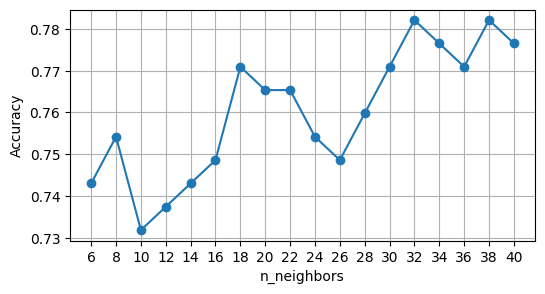

In [340]:
n_neighbors_list = list(range(6, 41, 2))
accuracy_scores = []

for n_neighbors in n_neighbors_list:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred_kn = knn.predict(X_test)
    accuracy_kn = accuracy_score(y_test, y_pred_kn)
    accuracy_scores.append(accuracy_kn)

# Plot the accuracy scores
plt.figure(figsize=(6, 3))
plt.plot(n_neighbors_list, accuracy_scores, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(np.arange(6, 42, step=2))
plt.show()

In [341]:
knn = KNeighborsClassifier(n_neighbors=32)
knn.fit(X_train, y_train)
y_pred_kn=knn.predict(X_test)
accuracy_kn = accuracy_score(y_test, y_pred_kn)

print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred_kn))
print("Classification Report:\n",classification_report(y_test, y_pred_kn))
print("Accuracy:", accuracy_kn)

Confusion Matrix:
 [[48 24]
 [15 92]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.67      0.71        72
           1       0.79      0.86      0.83       107

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179

Accuracy: 0.7821229050279329


In [342]:
# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  
}

# Instantiate the Logistic Regression classifier
lr = LogisticRegression()

# Instantiate GridSearchCV
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_lr = grid_search.best_estimator_

# Make predictions on the test data
y_pred_lr = best_lr.predict(X_test)

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy_lr)

Best Parameters: {'C': 10}
Accuracy: 0.7932960893854749


In [343]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [325, 350, 375],
    'max_depth': [9, 10, 11],
    'min_samples_leaf': [1, 2, 3]
}

# Create the Random Forest classifier
rf_gs = RandomForestClassifier(random_state=20)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_gs, param_grid=param_grid, cv=20, scoring='accuracy')

# Perform grid search on training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Train the model with the best parameters
best_rf = RandomForestClassifier(**best_params, random_state=20)
best_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = best_rf.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Test Accuracy with Best Parameters:", accuracy_rf)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 350}
Best Accuracy: 0.733015873015873
Test Accuracy with Best Parameters: 0.7877094972067039


- I tried hypertuning the RF classifier but saw that it matched the accuracy score of the out of bag RFCLF. 

In [344]:
weights = [1, 1, 1]
# Instantiate the VotingClassifier with soft voting
voting_clf = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('knn', knn)], voting='hard', weights=weights)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_voting = voting_clf.predict(X_test)

# Calculate accuracy
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print("Voting Classifier Accuracy:", accuracy_voting)
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred_voting))
print("Classification Report:\n",classification_report(y_test, y_pred_voting))

Voting Classifier Accuracy: 0.8100558659217877
Confusion Matrix:
 [[55 17]
 [17 90]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76        72
           1       0.84      0.84      0.84       107

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



- Voting was used in an effort to increase accuracy of model.
- Hard voting was used as the accuracy was increased makes sense in a classification model compared to soft voting that would use confidence probabilities.

- From the classification report we can see 55 TN 90 TP, with 17 FP and 17 FN. 
- The key number from the classification report is that the precision of positives class i.e. High traffic is 84% so the model should correctly choose more than 80% recipes that would lead to high traffic when using the model.

**Model Evaluation**

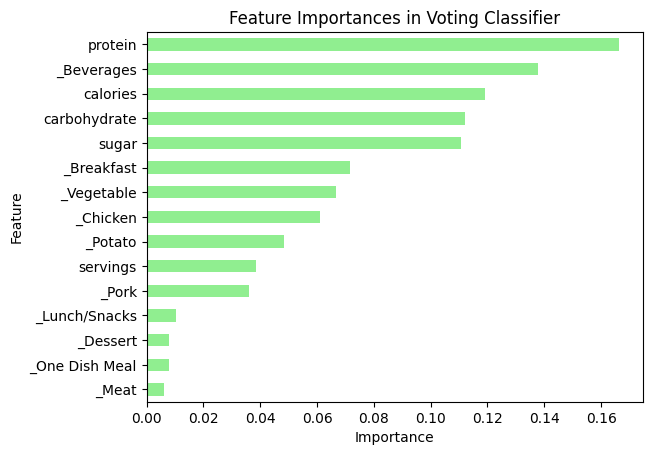

In [345]:
feature_importances = {}

# Loop over each base estimator in the voting classifier
for name, estimator in voting_clf.named_estimators_.items():
    # Check if the estimator has the attribute 'feature_importances_'
    if hasattr(estimator, 'feature_importances_'):
        # Store the feature importances in the dictionary
        feature_importances[name] = estimator.feature_importances_

# Create a DataFrame from the dictionary
importances_df = pd.DataFrame(feature_importances, index=X.columns)

# Calculate the mean importance across all base estimators
mean_importances = importances_df.mean(axis=1)

# Sort importances
sorted_importances = mean_importances.sort_values()

# Make a horizontal bar plot
sorted_importances.plot(kind='barh', color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Voting Classifier')
plt.show()

- The feature importances tell us the importantance of features in predicting high traffic. If we compare beverages, breakfast categories to the high traffic categories, they were the lowest traffic so it shows the importance of choosing the right category.

**Business Metrics**

Metric used to monitor success of model:

- Do the new recipes that fit the high traffic classification with in the model actually have high traffic? i.e. does traffic to the rest of the site go up by ~40% (as stated brief) or more when we display recipes that the model classify as high traffic? or at least 80% of the time?
- Are subscriptions actually increasing as a result of choosing these recipes?
- Improvements is to have the high_traffic category as a continous variable so we could run regression models to see look at those with the highest amount of traffic. 


Business goal:
- From the data set we had 574 of 947 recipes that had high traffic so this was about 61% of recipes that were displayed had high traffic. From the new recipes that we choose, we should have ~80% high traffic recipes that are displayed. We could measure this over the next time period and see if we are reaching this percentage or at least improved upon the 61%. 
- The KPI is therefore the percentage of recipes that had high traffic, and the model accuracy is the ability for the model to correctly predict that a recipe would have high traffic. 
- While using each model alone all had accuracy scores under 80%, by using a voting classifier we were able to achieve an accuracy above 80% and meeting the brief of predicting high traffic recipes at least 80% of the time. With 84% accuracy on predicting the positive class (high traffic) we are extremely pleased with the ensemble voting classifier


Recommendation:
- From the data produced, we should limit the amount of Beverage recipes and show recipes that tend to be pork, potato or vegetable (chicken had a proportionally larger amount displayed). 
- We should ensure that data collected does not have missing values, therefore, we have the values for protein, carbohydrate, calories and sugar, so that the model can properly predict whether it will have high traffic, and ensure that we are collecting when there is low traffic (so we can properly interpret the target variable) and continuously train the model with each added recipe once we have the result of the traffic.


## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation